In [21]:
from shapely.geometry import Point, mapping
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster, Fullscreen
from branca.element import MacroElement
from jinja2 import Template

In [2]:
wego = pd.read_csv("../data/headway_data_8-1-23_9-30-23.csv")

pd.set_option('display.max_columns', None) #shows every column in preview pane

pd.reset_option('display.max_columns') #resets above

pd.set_option('display.max_rows', None)

pd.reset_option('display.max_rows')

1. What is the overall on-time performance, and what do the overall distribution of adherence look like?

In [3]:
wego.shape

(350329, 30)

In [4]:
#based on tarik's
#this function doesn't account for any overload_id that also qualifies as an adjusted_ontime_count
#in order to achieve that, an extra layer of specificity is req'd by using .loc[] and setting the adjusted_ontime_count ==1
OT_total = wego['ADJUSTED_ONTIME_COUNT'].sum()
EARLY_total = wego['ADJUSTED_EARLY_COUNT'].sum()
LATE_total = wego['ADJUSTED_LATE_COUNT'].sum()
grand_total = OT_total + EARLY_total + LATE_total
OT_performance = round((OT_total/grand_total)*100,2)
print(OT_total)
print(EARLY_total)
print(LATE_total)
print(grand_total)
print(f"Overall on-time performance is {OT_performance}%")

270048
9775
59038
338861
Overall on-time performance is 79.69%


In [8]:
#isabelle's adjusted function
on_time_performance = wego.loc[wego['ADJUSTED_ONTIME_COUNT']==1]
#on_time_performance = on_time_performance.loc[on_time_performance['TRIP_EDGE'] != 2]
on_time_performance_pct = round((len(on_time_performance) / len(wego))*100,2)
print(on_time_performance_pct)

77.08


In [9]:
#routes = [3, 7, 22, 23, 50, 52, 55, 56]
#filtering = wego[wego['ROUTE_ABBR'].isin(routes)] ~this is kind of pointless as it is redundant
wego.groupby('ROUTE_ABBR')['ADHERENCE'].mean()
#print(route_totals)

ROUTE_ABBR
3    -3.761491
7    -3.346555
22   -1.138107
23   -1.760110
50   -2.505022
52   -3.971342
55   -4.823302
56   -2.703988
Name: ADHERENCE, dtype: float64

In [10]:
#isabelle's original function
#on_time_performance = wego.loc[wego['ADHERENCE'].between(-6,1)]
#on_time_performance = on_time_performance.loc[on_time_performance['TRIP_EDGE'] != 2]
#on_time_performance_pct = round((len(on_time_performance) / len(wego))*100,2)
#print(on_time_performance_pct)

2. How does direction of travel, route, or location affect the on-time performance?

In [11]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [12]:
wego['BLOCK_ABBR'].unique()

array([2200, 2201, 2202, 2210, 2211, 2300, 2301, 2302, 2303, 2310, 2311,
       2312, 2313,  300,  301,  302,  303,  304,  305,  310,  311,  312,
        313,  314,  315,  316,  317,  318,  319, 4101, 5000, 5001, 5002,
       5003, 5004, 5005, 5006, 5200, 5201, 5202, 5203, 5204, 5205, 5206,
       5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218, 5500, 5501,
       5502, 5503, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512,
       5513, 5592, 5593, 5594, 5600, 5601, 5602, 5603, 5604, 5605, 5606,
       5607, 5608, 5609, 5610, 5611,  700,  701,  702,  703,  704,  705,
        706, 2804,  390, 5094, 5590, 5690, 6401, 8401, 8405, 8601, 8604,
       9302, 9950, 9975], dtype=int64)

In [13]:
wego['BLOCK_ABBR'].value_counts()

BLOCK_ABBR
300     8894
2312    8532
2310    8233
5003    8086
5004    8048
        ... 
5094      72
8405      72
6401      72
5690      72
9975      72
Name: count, Length: 102, dtype: int64

In [14]:
block_count = wego[wego['ADJUSTED_ONTIME_COUNT'] == 1]['BLOCK_ABBR'].value_counts().reset_index()
block_count.columns = ['BLOCK_ABBR', 'on_time_count']
block_count = block_count.sort_values(by='on_time_count', ascending=False)
block_count
#on_time_blocks = round((len('on_time_count') / len(wego))*100,2)
#on_time_blocks

,BLOCK_ABBR,on_time_count
0,5003,7134
1,2310,7002
2,5004,6884
3,300,6330
4,2311,6297
...,...,...
97,5094,37
98,5690,33
99,8401,32
100,8601,31


In [15]:
block_count['percent_of_total'] = round((block_count['on_time_count'] / len(wego)) * 100, 2)
print(block_count)

     BLOCK_ABBR  on_time_count  percent_of_total
0          5003           7134              2.04
1          2310           7002              2.00
2          5004           6884              1.97
3           300           6330              1.81
4          2311           6297              1.80
..          ...            ...               ...
97         5094             37              0.01
98         5690             33              0.01
99         8401             32              0.01
100        8601             31              0.01
101        5590             14              0.00

[102 rows x 3 columns]


In [16]:
on_time_performance = wego[wego['ADJUSTED_ONTIME_COUNT'] == 1] # on-time rows
on_time_performance_pct = round((len(on_time_performance) / len(wego)) * 100, 2) # overall ot performance pct
print("Overall on-time performance is", on_time_performance_pct, "%")
block_count = on_time_performance['BLOCK_ABBR'].value_counts().reset_index()
block_count.columns = ['BLOCK_ABBR', 'on_time_count']
block_count = block_count.sort_values(by='on_time_count', ascending=False) # count on-time per block and calculate percent of total dataset
block_count['percent_of_total'] = round((block_count['on_time_count'] / len(wego)) * 100, 2) # % of total col
block_count

Overall on-time performance is 77.08 %


,BLOCK_ABBR,on_time_count,percent_of_total
0,5003,7134,2.04
1,2310,7002,2.00
2,5004,6884,1.97
3,300,6330,1.81
4,2311,6297,1.80
...,...,...,...
97,5094,37,0.01
98,5690,33,0.01
99,8401,32,0.01
100,8601,31,0.01


In [17]:
on_time_performance = wego[wego['ADJUSTED_ONTIME_COUNT'] == 1] # on-time rows
on_time_performance.count()

CALENDAR_ID                  270048
SERVICE_ABBR                 270048
ADHERENCE_ID                 270048
DATE                         270048
ROUTE_ABBR                   270048
BLOCK_ABBR                   270048
OPERATOR                     270048
TRIP_ID                      270048
OVERLOAD_ID                  270048
ROUTE_DIRECTION_NAME         270048
TIME_POINT_ABBR              270048
ROUTE_STOP_SEQUENCE          270047
TRIP_EDGE                    270048
LATITUDE                     270048
LONGITUDE                    270048
SCHEDULED_TIME               270048
ACTUAL_ARRIVAL_TIME          270048
ACTUAL_DEPARTURE_TIME        270048
ADHERENCE                    270048
SCHEDULED_HDWY               211467
ACTUAL_HDWY                  211421
HDWY_DEV                     211299
ADJUSTED_EARLY_COUNT         270048
ADJUSTED_LATE_COUNT          270048
ADJUSTED_ONTIME_COUNT        270048
STOP_CANCELLED               270048
PREV_SCHED_STOP_CANCELLED    215903
IS_RELIEF                   

C:\Users\jcbja\AppData\Local\Temp\ipykernel_242676\1225804389.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


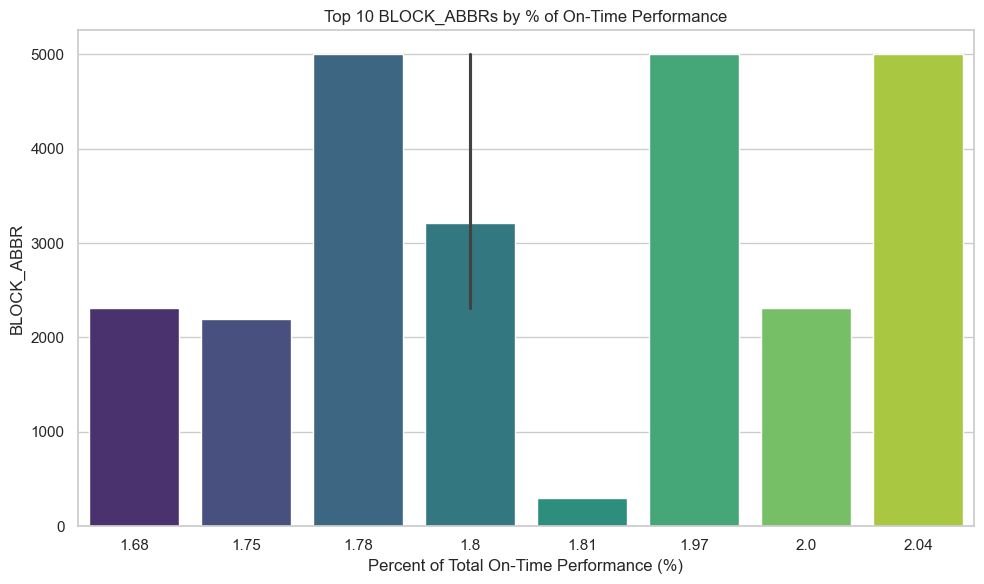

In [22]:
# Set plot style
sns.set(style="whitegrid")

# Plot top 10 on-time blocks
top_n = 10
plt.figure(figsize=(10, 6))
sns.barplot(
    data=block_count.head(top_n),
    x='percent_of_total',
    y='BLOCK_ABBR',
    palette='viridis'
)

plt.title(f"Top {top_n} BLOCK_ABBRs by % of On-Time Performance")
plt.xlabel("Percent of Total On-Time Performance (%)")
plt.ylabel("BLOCK_ABBR")
plt.tight_layout()
plt.show()

In [23]:
RD_OT = wego.groupby('ROUTE_DIRECTION_NAME')['ADJUSTED_ONTIME_COUNT'].sum()
RD_EARLY = wego.groupby('ROUTE_DIRECTION_NAME')['ADJUSTED_EARLY_COUNT'].sum()
RD_LATE = wego.groupby('ROUTE_DIRECTION_NAME')['ADJUSTED_LATE_COUNT'].sum()
RD_GT = RD_OT + RD_EARLY + RD_LATE
RD_OT_PERF = round((RD_OT/RD_GT)*100,2)
print(RD_GT)
print(RD_OT_PERF)

ROUTE_DIRECTION_NAME
FROM DOWNTOWN    179306
TO DOWNTOWN      159555
dtype: int64
ROUTE_DIRECTION_NAME
FROM DOWNTOWN    74.96
TO DOWNTOWN      85.01
dtype: float64


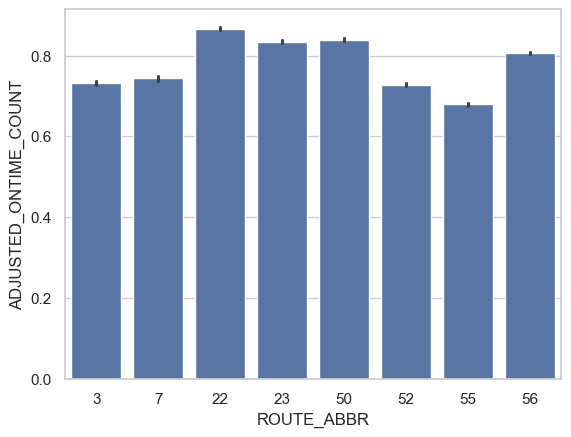

In [24]:
sns.barplot(x='ROUTE_ABBR', y='ADJUSTED_ONTIME_COUNT', data=wego)
plt.show()

3. How does time of day or day of week affect on-time performance?

4. How much of a factor does the driver have on on-time performance? The driver is indicated by the OPERATOR variable.

In [25]:
# i want to find the difference between 'SCHEDULED_TIME' and 'ACTUAL_ARRIVAL_TIME' and find the average across each 'OPERATOR' for each 'TRIP_ID'?

In [26]:
trip_id = wego.groupby('OPERATOR')['ADHERENCE'].mean()

trip_id

OPERATOR
0       8.916666
56     -1.138889
235    -3.947222
244    -3.466666
301    -4.971171
          ...   
3149   -0.993939
3156   -4.489942
3165   -7.501562
3166   -2.473333
3173   -2.591666
Name: ADHERENCE, Length: 341, dtype: float64

In [27]:
trip_id.describe()

count    341.000000
mean      -3.446736
std        2.649127
min      -22.066666
25%       -4.351053
50%       -3.147859
75%       -1.935147
max        8.916666
Name: ADHERENCE, dtype: float64

In [28]:
wego['OPERATOR'].value_counts()

OPERATOR
2352    2970
1266    2911
1147    2710
1133    2625
2424    2577
        ... 
2256       6
56         3
473        2
0          1
656        1
Name: count, Length: 341, dtype: int64

In [29]:
print(len(trip_id))

341


In [30]:
on_time_performance = wego[wego['ADJUSTED_ONTIME_COUNT'] == 1] # on-time rows
on_time_performance_pct = round((len(on_time_performance) / len(wego)) * 100, 2) # overall ot performance pct
print("Overall on-time performance is", on_time_performance_pct, "%")
operator_count = on_time_performance['OPERATOR'].value_counts().reset_index()
operator_count.columns = ['OPERATOR', 'on_time_count']
operator_count = operator_count.sort_values(by='on_time_count', ascending=False) # count on-time per block and calculate percent of total dataset
operator_count['percent_of_total'] = round((operator_count['on_time_count'] / len(wego)) * 100, 2) # % of total col
operator_count

Overall on-time performance is 77.08 %


,OPERATOR,on_time_count,percent_of_total
0,1266,2522,0.72
1,1133,2505,0.72
2,1147,2439,0.70
3,1927,2317,0.66
4,409,2310,0.66
...,...,...,...
334,235,6,0.00
335,2256,5,0.00
336,56,3,0.00
337,2982,2,0.00


In [31]:
wego['OPERATOR'].value_counts()

OPERATOR
2352    2970
1266    2911
1147    2710
1133    2625
2424    2577
        ... 
2256       6
56         3
473        2
0          1
656        1
Name: count, Length: 341, dtype: int64

In [32]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


5. Is there any relationship between lateness (ADHERENCE) and headway deviation? The headway deviation variable is contained in the HDWY_DEV column. See the notes under number 9 for a description of headway and headway deviation.

In [33]:
wego['ADHERENCE'] = wego['ADHERENCE'].astype(float)
wego['HDWY_DEV'] = wego['HDWY_DEV'].astype(float)

In [34]:
wego[['ADHERENCE', 'HDWY_DEV']].corr()

,ADHERENCE,HDWY_DEV
ADHERENCE,1.000000,-0.206794
HDWY_DEV,-0.206794,1.000000


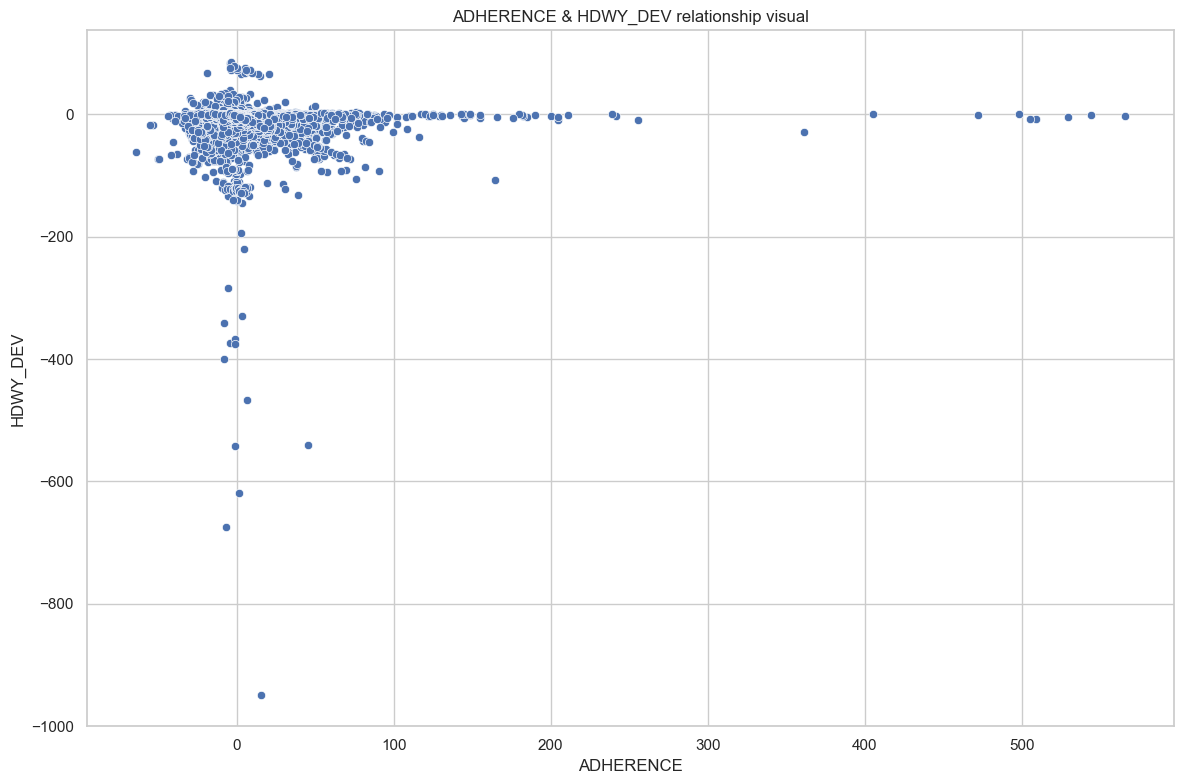

In [35]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=wego,
    x='HDWY_DEV',
    y='ADHERENCE'
)

plt.title(f"ADHERENCE & HDWY_DEV relationship visual")
plt.xlabel("ADHERENCE")
plt.ylabel("HDWY_DEV")
plt.tight_layout()
plt.show()

6. How much impact does being late or too spaced out at the first stop have downstream?

In [36]:
# look for an 'ADHERENCE' value of -6.0 or less to filter for late first stops

In [37]:
wego.groupby('OPERATOR')['ROUTE_ABBR'].value_counts().to_frame()

count
OPERATOR ROUTE_ABBR       
0        23              1
56       56              3
235      23             12
244      55             25
301      55             37
...                    ...
3156     3             172
         50            132
3165     23             32
3166     55             35
3173     22             22

[1159 rows x 1 columns]

In [38]:
from shapely.geometry import Point, mapping, LineString
import geopandas as gpd
import pandas as pd
import folium
from folium import PolyLine
from folium.plugins import MarkerCluster, Fullscreen
from folium.features import CustomIcon
from branca.element import MacroElement
from jinja2 import Template
import matplotlib.cm as cm
import matplotlib.colors as colors

# read the wego csv
wego = pd.read_csv("../data/headway_data_8-1-23_9-30-23.csv")

# load shapefiles and project to wgs84
routes = gpd.read_file('../data/Intercity_Bus_Atlas_Routes.shp').to_crs(epsg=4326)
stops = gpd.read_file('../data/Intercity_Bus_Atlas_Stops.shp').to_crs(epsg=4326)
counties = gpd.read_file('../data/county/tncounty.shp').to_crs(epsg=4326)

# define middle tn region (nashville area)
middle_tn_counties = counties[counties['NAME'].isin(['Davidson', 'Williamson', 'Rutherford', 'Sumner', 'Wilson', 'Robertson', 'Cheatham'])]
nashville_area = gpd.GeoDataFrame(geometry=[middle_tn_counties.unary_union], crs=routes.crs)
nashville_geom = nashville_area.geometry.iloc[0]

# filter routes to target list and intersecting geometry
target_routes = ['3', '7', '22', '23', '50', '52', '55', '56']
routes_filtered = routes[routes['route_id'].astype(str).isin(target_routes)]
routes_filtered = routes_filtered[routes_filtered.geometry.intersects(nashville_geom)]

# isolate route 56
route_56_line = routes_filtered[routes_filtered['route_id'].astype(str) == '56']

# buffer routes in projected crs
routes_projected = routes_filtered.to_crs(epsg=3857)
routes_projected['geometry'] = routes_projected.buffer(30)

# reproject stops and spatial join with buffered routes
stops_projected = stops.to_crs(epsg=3857)
stops_near_filtered_routes = gpd.sjoin(stops_projected, routes_projected, how='inner', predicate='intersects')

# reproject both back to wgs84
routes_filtered = routes_projected.to_crs(epsg=4326)
stops_near_filtered_routes = stops_near_filtered_routes.to_crs(epsg=4326)

# group raw wego data into geodataframe
wego_gdf = gpd.GeoDataFrame(
    wego,
    geometry=gpd.points_from_xy(wego['LONGITUDE'], wego['LATITUDE']),
    crs='EPSG:4326'
)

# buffer stops slightly for spatial join
buffered_stops = stops_near_filtered_routes.to_crs(epsg=3857)
buffered_stops['geometry'] = buffered_stops.geometry.buffer(35)
buffered_stops = buffered_stops.to_crs(epsg=4326)

# spatial join wego data with buffered stops
wego_with_stop_info = gpd.sjoin(
    wego_gdf,
    buffered_stops[['stop_id', 'stop_name', 'geometry']],
    how='left',
    predicate='within'
)
wego_with_stop_info = wego_with_stop_info.dropna(subset=['stop_id'])

# filter to valid stop ids
valid_stop_ids = set(stops_near_filtered_routes['stop_id'].astype(str))
wego_with_stop_info['stop_id'] = wego_with_stop_info['stop_id'].astype(str)
wego_filtered = wego_with_stop_info[wego_with_stop_info['stop_id'].isin(valid_stop_ids)]

# calculate on-time percentage per stop
wego_counts = wego_filtered.groupby([
    'stop_id', 'stop_name', 'ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'LATITUDE', 'LONGITUDE'
]).agg({
    'ADJUSTED_EARLY_COUNT': 'sum',
    'ADJUSTED_ONTIME_COUNT': 'sum',
    'ADJUSTED_LATE_COUNT': 'sum',
    'ADHERENCE': 'mean'
}).reset_index()

wego_counts['ONTIME_PCT'] = round(
    (wego_counts['ADJUSTED_ONTIME_COUNT'] / (
        wego_counts['ADJUSTED_ONTIME_COUNT'] + wego_counts['ADJUSTED_LATE_COUNT'] + wego_counts['ADJUSTED_EARLY_COUNT']
    )) * 100, 2
)

# icon assignment based on on-time %
def get_icon_image(ontime_pct):
    if ontime_pct >= 90:
        return '../data/green_marker.png'
    elif ontime_pct >= 70:
        return '../data/orange_marker.png'
    else:
        return '../data/red_marker.png'

# create folium map
m1 = folium.Map(location=[36.1627, -86.7816], tiles='cartodbpositron', zoom_start=14)
marker_cluster = MarkerCluster(zoomToBoundsOnClick=False, spiderfyOnMaxZoom=True, disableClusteringAtZoom=14, maxClusterRadius=50).add_to(m1)
Fullscreen(position="topright").add_to(m1)

# add legend
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: absolute; bottom: 10px; left: 50%; transform: translateX(-50%);
    width: 220px; border: 2px solid grey; z-index: 10000; font-size: 14px;
    background-color: white; padding: 10px; box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
    border-radius: 8px; display: block; text-align: left;">
<b>On-Time %</b><br>
<i style="background:green; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> Light (≥ 90%)<br>
<i style="background:orange; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> Medium (70–89%)<br>
<i style="background:red; width:10px; height:10px; float:left; margin-right:5px; display:inline-block;"></i> Heavy (< 70%)<br>
</div>
{% endmacro %}
"""
legend = MacroElement()
legend._template = Template(legend_html)
m1.get_root().add_child(legend)

# draw route 56 as gradient
colormap = cm.get_cmap('rainbow', 256)
norm = colors.Normalize(vmin=0, vmax=255)
for _, row in route_56_line.iterrows():
    geom = row['geometry']
    lines = list(geom.geoms) if geom.geom_type == 'MultiLineString' else [geom]
    for line in lines:
        coords = list(line.coords)
        for i in range(len(coords) - 1):
            segment = [coords[i], coords[i + 1]]
            color = colors.to_hex(colormap(norm(int(i * 255 / (len(coords) - 2)))))
            PolyLine(locations=[segment[0][::-1], segment[1][::-1]], color=color, weight=5, opacity=0.9).add_to(m1)

# add markers for wego stops
added_keys = set()
for _, row in wego_counts.iterrows():
    marker_key = (row['stop_id'], row['ROUTE_ABBR'], row['ROUTE_DIRECTION_NAME'])
    if marker_key not in added_keys:
        icon_path = get_icon_image(row['ONTIME_PCT'])
        custom_icon = CustomIcon(icon_image=icon_path, icon_size=(32, 32), icon_anchor=(16, 16))
        tooltip = folium.Tooltip(
            f"Stop ID: {row['stop_id']}<br>"
            f"Stop Name: {row['stop_name']}<br>"
            f"Route: {row['ROUTE_ABBR']}<br>"
            f"Direction: {row['ROUTE_DIRECTION_NAME']}<br>"
            f"Avg Adherence: {row['ADHERENCE']:.2f}<br>"
            f"On-Time %: {row['ONTIME_PCT']:.1f}%", sticky=True, direction='left'
        )
        folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], tooltip=tooltip, icon=custom_icon).add_to(marker_cluster)
        added_keys.add(marker_key)

# draw other filtered routes (excluding route 56)
for _, row in routes_filtered[routes_filtered['route_id'] != '56'].iterrows():
    route_feature = {
        "type": "Feature",
        "geometry": mapping(row['geometry']),
        "properties": {"route_id": row['route_id'], "route_long": row['route_long']}
    }
    folium.GeoJson(
        route_feature,
        tooltip=folium.GeoJsonTooltip(fields=["route_id", "route_long"], aliases=["Route ID:", "Route Name:"], sticky=True),
        style_function=lambda x: {'color': 'blue', 'weight': 3, 'opacity': .25},
        highlight_function=lambda x: {'weight': 5, 'color': 'blue', 'opacity': .85}
    ).add_to(m1)

# m1.save('nashville_bus_map_.html')


C:\Users\jcbja\AppData\Local\Temp\ipykernel_242676\3849938695.py:121: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('rainbow', 256)


In [39]:
import os
print(os.listdir('../data'))

['county', 'dfrobyj-9c2c32c8-ff25-4d88-b476-47f308815f90.jpg', 'green_marker.png', 'headway_data_8-1-23_9-30-23.csv', 'Intercity_Bus_Atlas_Routes.cpg', 'Intercity_Bus_Atlas_Routes.dbf', 'Intercity_Bus_Atlas_Routes.prj', 'Intercity_Bus_Atlas_Routes.shp', 'Intercity_Bus_Atlas_Routes.shp.xml', 'Intercity_Bus_Atlas_Routes.shx', 'Intercity_Bus_Atlas_Stops.cpg', 'Intercity_Bus_Atlas_Stops.dbf', 'Intercity_Bus_Atlas_Stops.prj', 'Intercity_Bus_Atlas_Stops.shp', 'Intercity_Bus_Atlas_Stops.shp.xml', 'Intercity_Bus_Atlas_Stops.shx', 'item_box.png', 'mario-kart.png', 'NTAD_Intercity_Bus_Atlas_Routes.csv', 'NTAD_Intercity_Bus_Atlas_Routes.geojson', 'NTAD_Intercity_Bus_Atlas_Stops.csv', 'NTAD_Intercity_Bus_Atlas_Stops.geojson', 'orange_marker.png', 'pct_stop_trip_route.csv', 'red_marker.png', 'super-mario-64-musik-stern-erhalt-fanfare-here-we-go.mp3', 'wego_stop_counts.csv', 'wego_stop_ids.csv']



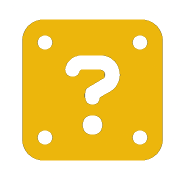
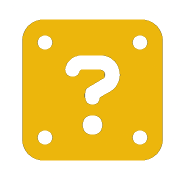
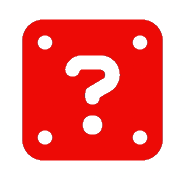
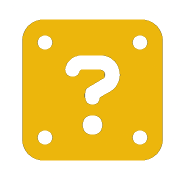
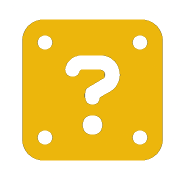
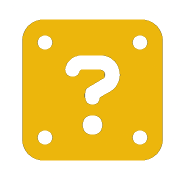
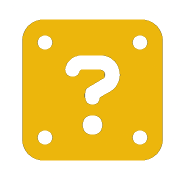
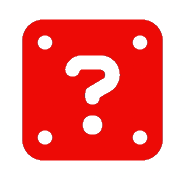
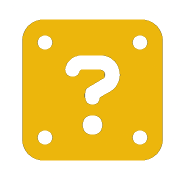
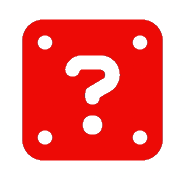
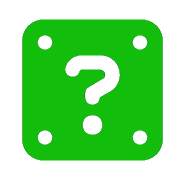
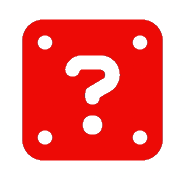
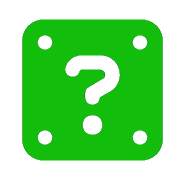
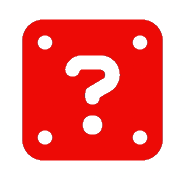
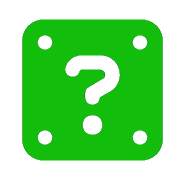
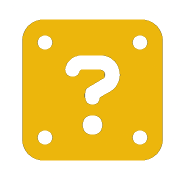
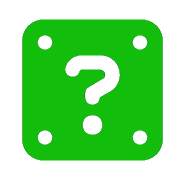
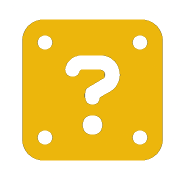
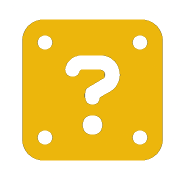
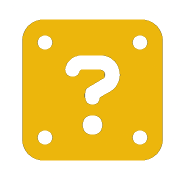
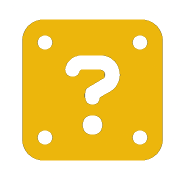
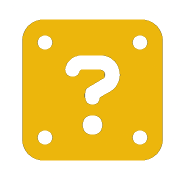
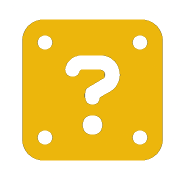
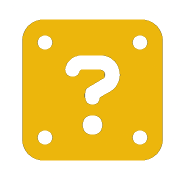
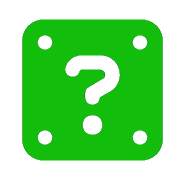
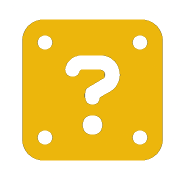
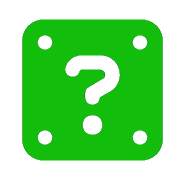
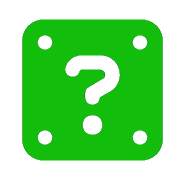
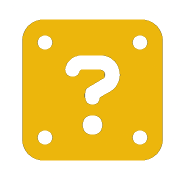
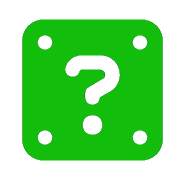
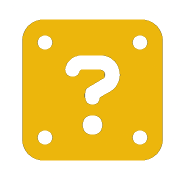
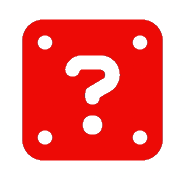
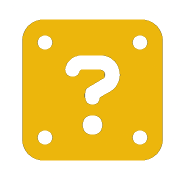
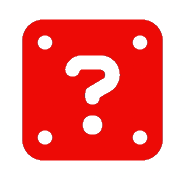
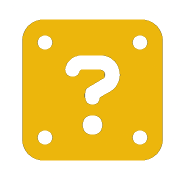
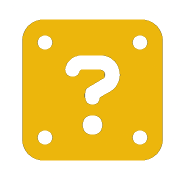
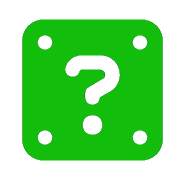
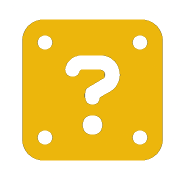
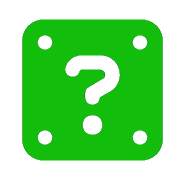
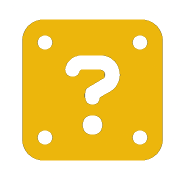
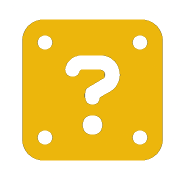
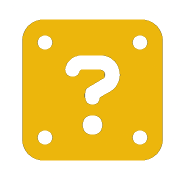
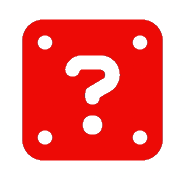
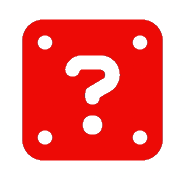
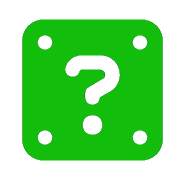
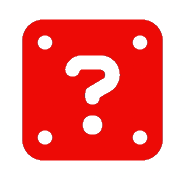
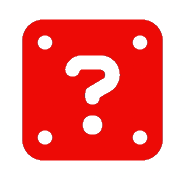
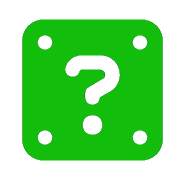
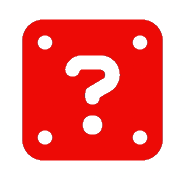
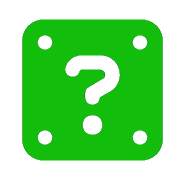
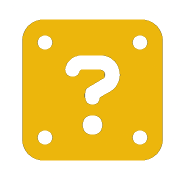
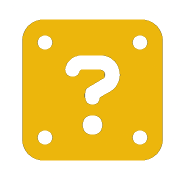
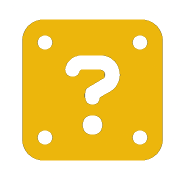
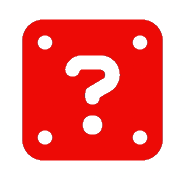
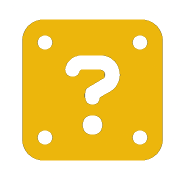
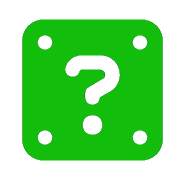
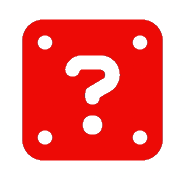
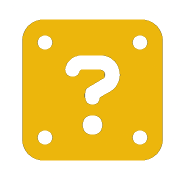
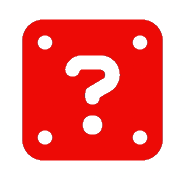
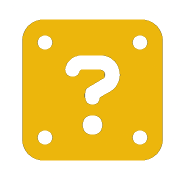
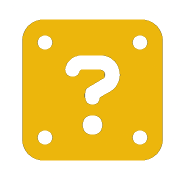
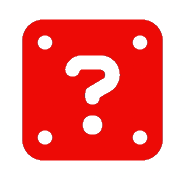
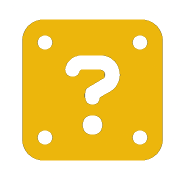
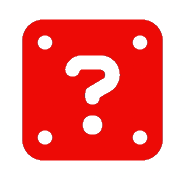
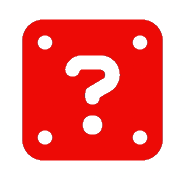
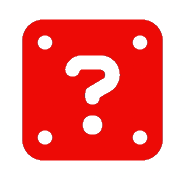
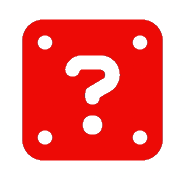
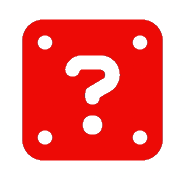
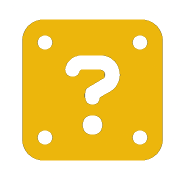
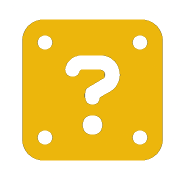
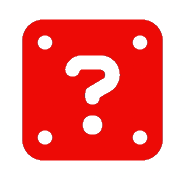
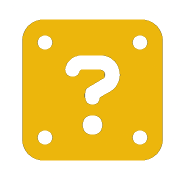
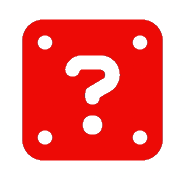
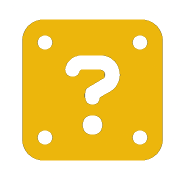
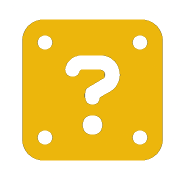
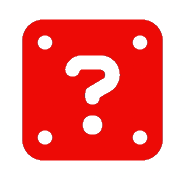
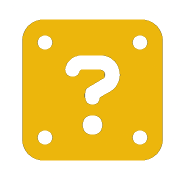
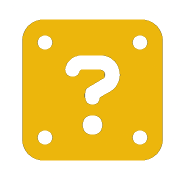
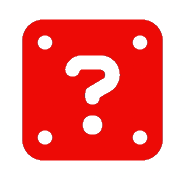
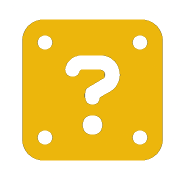
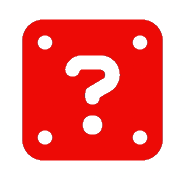
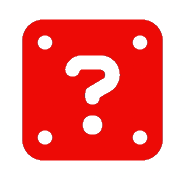
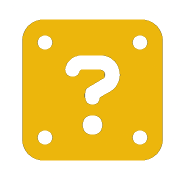

In [40]:
m1